In [5]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from math import pi, cos, sin
import random
import pickle

import glob, os

import seaborn as sns
import pandas as pd

from HW.utilities import plot_scatter

Dataset 1

In [6]:
def GenGMM(dim=2, groups_num=5, data_size=500, center_factor=2, min_distance=1, outliers=0):
    """
    generate clusters from random multivariate normal distributions.

    Parameters
    ----------
    dim : int, data dimension. Default: 2
    groups_num : int, number of clusters
    data_size : int, define a range [data_size, 5*data_size] from which the cluster sizes are randomly choosen.
                Default: 500
    center_factor : float, define a range [0, center_factor] from which the cluster cntroids are randomly choosen.
                    Default: 2
    min_distance : float, define the minimum Euclidean distance between the clusters.
                   Note, this is not always can be stratified, and the generator can stuck. Default: 1
    outliers : int, define the number of outliear which will be randomly added to the dataset. Default: 0

    Returns
    -------
    data : List that holds the cluster data. For example, [xks_1, xks_2, ...]
           where xks_i is a numpy array of n datapints of dimension m (n,m) of cluster i
    mus : List that holds the clusters means/centroids. For example, [mu_1, mu_2, ...]
          where mu_i is a numpy array (m, 1) or (m,) of the mean of cluster i.
    sigmas : List holds the clusters covariance matrices. For example, [sigma_1, sigma_2, ...]
             where sigma_i is a numpy array (m, m) of the covariance of cluster i.
    """
    # try to find random centers that stasfiy the min_distance
    max_iters = 100000
    not_generated = True
    while not_generated:
        # first cluster center
        mus = np.random.rand(1, dim) * center_factor
        # set the other clusters' centers
        for i in range(groups_num - 1):
            mu = np.random.rand(1, dim) * center_factor
            conds = (np.sum((mus - mu) ** 2, axis=1) ** 0.5) >= min_distance
            iter_i = 0
            while (not conds.all()) and iter_i < max_iters:
                iter_i += 1
                mu = np.random.rand(1, dim) * center_factor
                conds = (np.sum((mus - mu) ** 2, axis=1) ** 0.5) >= min_distance
            if iter_i >= max_iters:
                break
            mus = np.vstack((mus, mu))
        if iter_i >= max_iters:
            continue
        not_generated = False  
    # random sigmas
    sigmas = np.stack([datasets.make_spd_matrix(dim) for set in range(groups_num)])
    # random sizes in range
    data_sizes = np.random.randint(low=data_size, high=5*data_size, size=groups_num)

    # smaple the data
    data = []
    for i in range(groups_num):
        set_data = np.random.multivariate_normal(mus[i, :], sigmas[i, :, :], (data_sizes[i]))
        data.append(set_data)
    if outliers != 0:
        outliers = np.random.rand(outliers, dim) * (1.5 * center_factor)
        data.append(outliers)
    return data, mus, sigmas

In [294]:
groups_num = 5
dim = 5
center_factor = 3
min_distance = 0.5
data_size = 500
outliers = 0
data, mus, sigmas = GenGMM(dim=dim, groups_num=groups_num, data_size=data_size, center_factor=center_factor, min_distance=min_distance, outliers=outliers)

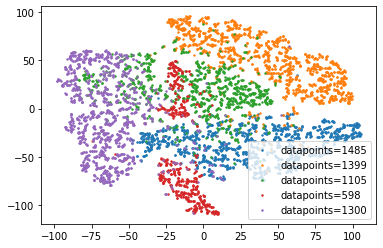

In [295]:
plot_scatter(data, reduction_type="TSNE", outliers=False)

In [296]:
with open('outputs/dataset_1_random_{}D_{}_GMM_min_distance_{}_center_factor_{}_outliers_{}.pickle'.format(
    dim, groups_num, min_distance, center_factor, outliers), 'wb') as handle:
    pickle.dump([data, mus, sigmas], handle, protocol=pickle.HIGHEST_PROTOCOL)

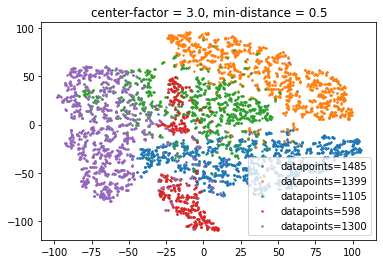

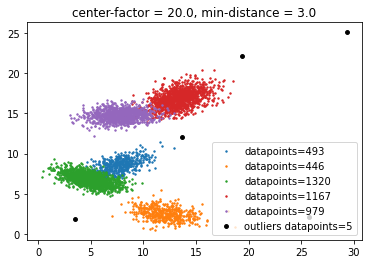

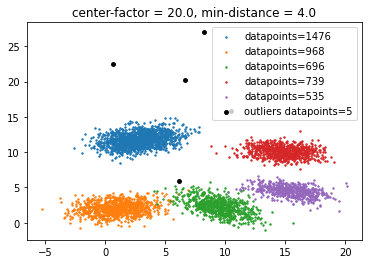

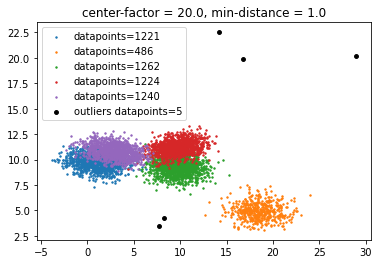

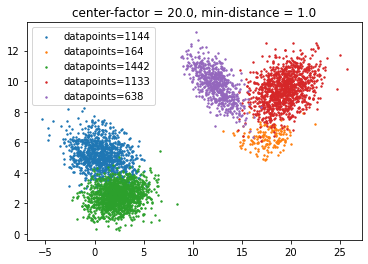

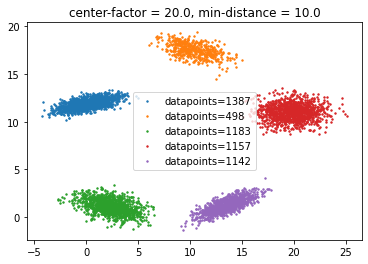

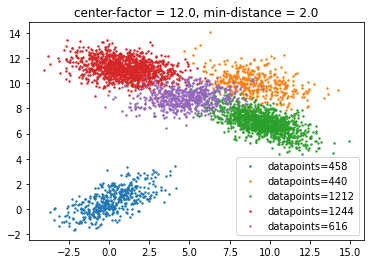

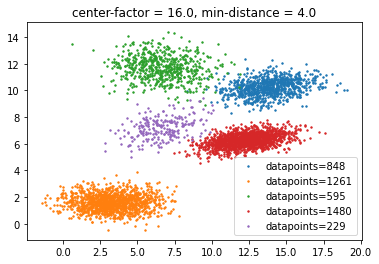

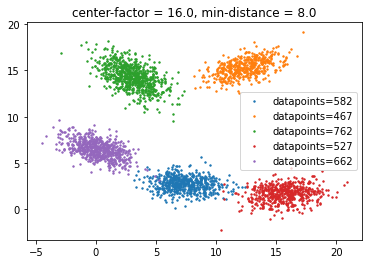

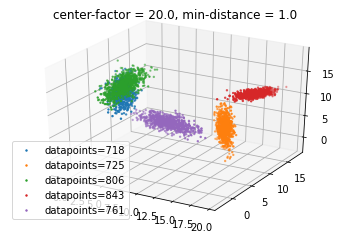

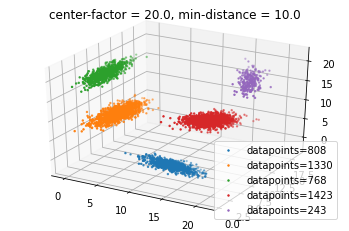

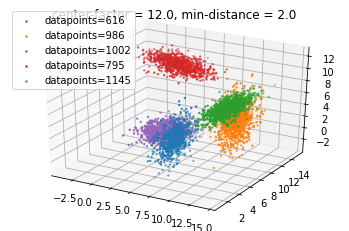

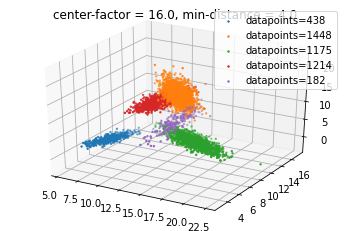

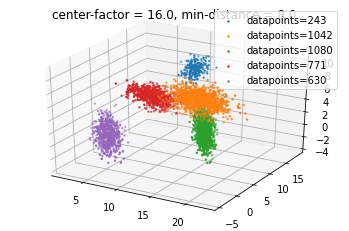

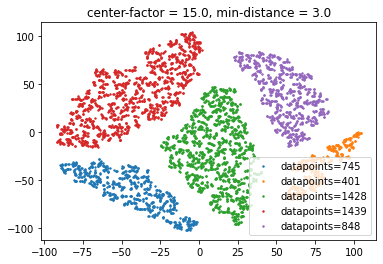

In [298]:
for file in glob.glob("outputs/dataset_1*.pickle"):
    min_distnace_start = file.find("min_distance")
    min_distance_end = file.find("_center_factor")
    min_distnace = float(file[min_distnace_start:min_distance_end].split("_")[2])
    
    center_factor_start = file.find("center_factor")
    center_factor_end = file.find("_outliers")
    center_factor = float(file[center_factor_start:center_factor_end].split("_")[2])
    
    outliers_start = file.find("outliers")
    outliers_end = file.find(".pickle")
    outliers = int(file[outliers_start:outliers_end].split("_")[1])
    outliers = True if outliers > 0 else False
    
    with open(file, 'rb') as handle:
        [data, mus, sigmas] = pickle.load(handle)
    plot_scatter(data, reduction_type="TSNE", outliers=outliers, file_name=file[:-7],
             title="center-factor = {}, min-distance = {}".format(center_factor, min_distnace))

Dataset 2

based on

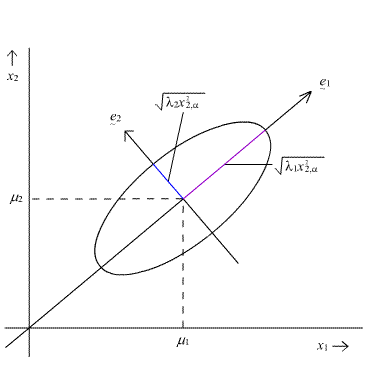

In [7]:
def rectangle(height, width, center_factor, rotation_angle=None, noise=True, data_size=1000):
    """
    generate 2D rectangle clusters from random multivariate normal distributions.

    Parameters
    ----------
    height : float, height of the rectangle
    width : float, width of the rectangle
    center_factor : float, define a range [0, center_factor] from which the rectangle center is randomly choosen.
    rotation_angle : float or None, define the rotation angle of the rectangle in radians.
                      If None, then do not rotate. Default: None 
    noise : Boolean, define whether to add random normal noise the rectangle lines. Default: True
    data_size : int, define a range [data_size, 5*data_size] from which the cluster sizes are randomly choosen.
                Default: 1000

    Returns
    -------
    data : List that holds the cluster data. For example, [xks_1, xks_2, ...]
           where xks_i is a numpy array of n datapints of dimension m (n,m) of cluster i
    mus : List that holds the clusters means/centroids. For example, [mu_1, mu_2, ...]
          where mu_i is a numpy array (m, 1) or (m,) of the mean of cluster i.
    sigmas : List holds the clusters covariance matrices. For example, [sigma_1, sigma_2, ...]
             where sigma_i is a numpy array (m, m) of the covariance of cluster i.
    """
    if rotation_angle is not None:
        R = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)], [np.sin(rotation_angle), np.cos(rotation_angle)]])
    else:
        R = np.eye(2)
    
    data_sizes = np.random.randint(low=data_size, high=5*data_size, size=4)
    center = np.random.rand(1, 2) * center_factor
    x, y = center[0,0], center[0,1]
    U = R @ np.array([[1, 0],[0, 1]])
    
    data = []
    mus = []
    sigmas = []
    
    # vertical
    EV = np.diag([0, 1]) if not noise else np.diag([np.abs(np.random.normal(0, 0.01, 1)), 1])
    mu = R @ np.array([x + width/2, y])
    S = U @ EV @ U.T
    mus.append(mu)
    sigmas.append(S)
    data.append(np.random.multivariate_normal(mu, S, data_sizes[0]))
    
    EV = np.diag([0, 1]) if not noise else np.diag([np.abs(np.random.normal(0, 0.01, 1)), 1])
    S = U @ EV @ U.T
    mu = R @ np.array([x - width/2, y])
    mus.append(mu)
    sigmas.append(S)
    data.append(np.random.multivariate_normal(mu, S, data_sizes[1]))
    
    # horizontal 
    EV = np.diag([1, 0]) if not noise else np.diag([1, np.abs(np.random.normal(0, 0.01, 1))])
    S = U @ EV @ U.T
    mu = R @ np.array([x, y + height/2])
    mus.append(mu)
    sigmas.append(S)
    data.append(np.random.multivariate_normal(mu, S, data_sizes[2]))
    
    EV = np.diag([1, 0]) if not noise else np.diag([1, np.abs(np.random.normal(0, 0.01, 1))])
    S = U @ EV @ U.T
    mu = R @ np.array([x, y - height/2])
    mus.append(mu)
    sigmas.append(S)
    data.append(np.random.multivariate_normal(mu, S, data_sizes[3]))
    
    return data, mus, sigmas

In [32]:
height=5
width=5
center_factor=10
data, mus, sigmas = rectangle(height=height, width=width, center_factor=center_factor, noise=False)

In [34]:
with open('outputs/dataset_2_rectangle_height_{}_width_{}_center_factor_{}_rotation_angle_0_noise_False.pickle'.format(
    height, width, center_factor), 'wb') as handle:
    pickle.dump([data, mus, sigmas], handle, protocol=pickle.HIGHEST_PROTOCOL)

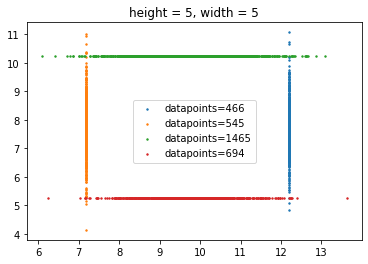

In [48]:
file = 'outputs/dataset_2_rectangle_height_{}_width_{}_center_factor_{}_rotation_angle_0_noise_False.pickle'.format(
        height, width, center_factor)
with open(file, 'rb') as handle:
        [data, mus, sigmas] = pickle.load(handle)
plot_scatter(data, reduction_type="TSNE", file_name=file[:-7],
             title="height = {}, width = {}".format(height, height))

In [35]:
height=5
width=5
center_factor=10
data, mus, sigmas = rectangle(height=height, width=width, center_factor=center_factor, noise=True)

In [37]:
with open('outputs/outputs/dataset_2_rectangle_height_{}_width_{}_center_factor_{}_rotation_angle_0_noise_True.pickle'.format(
    height, width, center_factor), 'wb') as handle:
    pickle.dump([data, mus, sigmas], handle, protocol=pickle.HIGHEST_PROTOCOL)

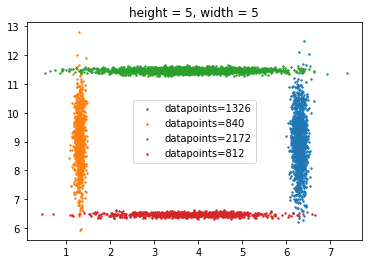

In [49]:
file = 'outputs/dataset_2_rectangle_height_{}_width_{}_center_factor_{}_rotation_angle_0_noise_True.pickle'.format(
        height, width, center_factor)
with open(file, 'rb') as handle:
        [data, mus, sigmas] = pickle.load(handle)
plot_scatter(data, reduction_type="TSNE", file_name=file[:-7],
             title="height = {}, width = {}".format(height, height))

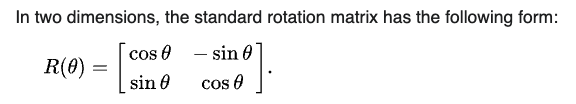

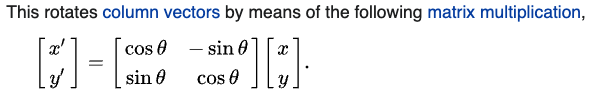

In [38]:
height=5
width=5
center_factor=10
data, mus, sigmas = rectangle(height=5, width=5, center_factor=10, rotation_angle=pi/4, noise=False)

In [40]:
with open('outputs/dataset_2_rectangle_height_{}_width_{}_center_factor_{}_rotation_angle_025pi_noise_False.pickle'.format(
    height, width, center_factor), 'wb') as handle:
    pickle.dump([data, mus, sigmas], handle, protocol=pickle.HIGHEST_PROTOCOL)

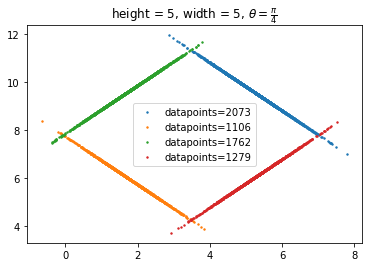

In [55]:
file = 'outputs/dataset_2_rectangle_height_{}_width_{}_center_factor_{}_rotation_angle_025pi_noise_False.pickle'.format(
        height, width, center_factor)
with open(file, 'rb') as handle:
        [data, mus, sigmas] = pickle.load(handle)
plot_scatter(data, reduction_type="TSNE", file_name=file[:-7],
             title="height = {}, width = {},".format(height, height) + " $\\theta = \\frac{\pi}{4}$")

In [43]:
data, mus, sigmas = rectangle(height=height, width=width, center_factor=center_factor, rotation_angle=pi/4, noise=True)

In [45]:
with open('outputs/dataset_2_rectangle_height_{}_width_{}_center_factor_{}_rotation_angle_025pi_noise_True.pickle'.format(
    height, width, center_factor), 'wb') as handle:
    pickle.dump([data, mus, sigmas], handle, protocol=pickle.HIGHEST_PROTOCOL)

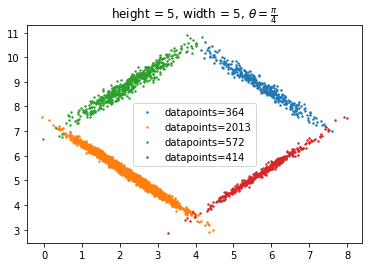

In [56]:
file = 'outputs/dataset_2_rectangle_height_{}_width_{}_center_factor_{}_rotation_angle_025pi_noise_True.pickle'.format(
        height, width, center_factor)
with open(file, 'rb') as handle:
        [data, mus, sigmas] = pickle.load(handle)
plot_scatter(data, reduction_type="TSNE", file_name=file[:-7],
             title="height = {}, width = {},".format(height, height) + " $\\theta = \\frac{\pi}{4}$")

In [71]:
def triangle(rotation_angle, noise=True, center_factor=15, data_size=1000, delta=2):
    """
    generate 2D Isosceles triangle clusters from random multivariate normal distributions.

    Parameters
    ----------
    rotation_angle : float, should define the rotation angle of the Isosceles triangle in radians.
    center_factor : float, define a range [0, center_factor] from which the Isosceles triangle base
                    centeter is randomly choosen. Default: 15
    noise : Boolean, define whether to add random normal noise the triangle lines. Default: True
    data_size : int, define a range [data_size, 5*data_size] from which the cluster sizes are randomly choosen.
                Default: 1000
    delta : float, left and right center [x,y] are defined by to the base center and delta.
            Right-leg-center: [x + delta, y + delta], Left-leg-center: [x - delta, y + delta].
            Default: 2

    Returns
    -------
    data : List that holds the cluster data. For example, [xks_1, xks_2, ...]
           where xks_i is a numpy array of n datapints of dimension m (n,m) of cluster i
    mus : List that holds the clusters means/centroids. For example, [mu_1, mu_2, ...]
          where mu_i is a numpy array (m, 1) or (m,) of the mean of cluster i.
    sigmas : List holds the clusters covariance matrices. For example, [sigma_1, sigma_2, ...]
             where sigma_i is a numpy array (m, m) of the covariance of cluster i.
    """
    data_sizes = np.random.randint(low=data_size, high=5*data_size, size=3)
    center = np.random.rand(1, 2) * center_factor
    x, y = center[0,0], center[0,1]
    U = np.array([[1, 0],[0, 1]])
    
    data = []
    mus = []
    sigmas = []
    
    # horizontal
    EV = np.diag([1, 0]) if noise else np.diag([1, np.abs(np.random.normal(0, 0.01, 1))])
    mu = np.array([x, y])
    S = U @ EV @ U.T
    mus.append(mu)
    sigmas.append(S)
    data.append(np.random.multivariate_normal(mu, S, data_sizes[0]))
    
    # Left
    R = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)], [np.sin(rotation_angle), np.cos(rotation_angle)]])
    U_L = R @ U
    EV = np.diag([1, 0]) if noise else np.diag([1, np.abs(np.random.normal(0, 0.01, 1))])
    mu = np.array([x - delta, y + delta])
    S = U_L @ EV @ U_L.T
    mus.append(mu)
    sigmas.append(S)
    data.append(np.random.multivariate_normal(mu, S, data_sizes[1]))
    
    # Right
    R = np.array([[np.cos(-rotation_angle), -np.sin(-rotation_angle)], [np.sin(-rotation_angle), np.cos(-rotation_angle)]])
    U_R = R @ U
    EV = np.diag([1, 0]) if noise else np.diag([1, np.abs(np.random.normal(0, 0.01, 1))])
    mu = np.array([x + delta, y + delta])
    S = U_R @ EV @ U_R.T
    mus.append(mu)
    sigmas.append(S)
    data.append(np.random.multivariate_normal(mu, S, data_sizes[2]))
    
    return data, mus, sigmas

In [72]:
data, mus, sigmas = triangle(rotation_angle=pi/4, noise=False, data_size=1000)

In [74]:
with open('outputs/dataset_2_triangle_rotation_angle_025pi_noise_False.pickle', 'wb') as handle:
    pickle.dump([data, mus, sigmas], handle, protocol=pickle.HIGHEST_PROTOCOL)

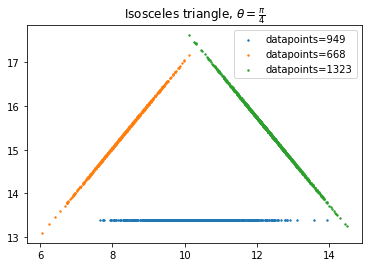

In [75]:
file = 'outputs/dataset_2_triangle_rotation_angle_025pi_noise_False.pickle'
plot_scatter(data, reduction_type="TSNE", file_name=file[:-7],
             title="Isosceles triangle," + " $\\theta = \\frac{\pi}{4}$")

In [78]:
data, mus, sigmas = triangle(rotation_angle=pi/4, noise=True, data_size=1000)

In [80]:
with open('outputs/dataset_2_triangle_rotation_angle_025pi_noise_True.pickle', 'wb') as handle:
    pickle.dump([data, mus, sigmas], handle, protocol=pickle.HIGHEST_PROTOCOL)

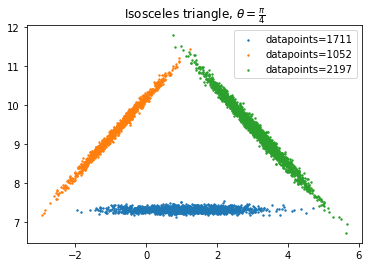

In [81]:
file = 'outputs/dataset_2_triangle_rotation_angle_025pi_noise_True.pickle'
plot_scatter(data, reduction_type="TSNE", file_name=file[:-7],
             title="Isosceles triangle," + " $\\theta = \\frac{\pi}{4}$")

In [62]:
def cross(rotation_angle_1, rotation_angle_2, noise=True, center_factor=15, data_size=1000):
    """
    generate 2D cross dataset from random multivariate normal distributions.

    Parameters
    ----------
    rotation_angle_1 : float, define the rotation angle of the first line in cross in radians.
    rotation_angle_1 : float, define the rotation angle of the second line in cross in radians.
    noise : Boolean, define whether to add random normal noise the lines. Default: True
    center_factor : float, define a range [0, center_factor] from which the line centeters are randomly choosen.
                    Default: 15
    data_size : int, define a range [data_size, 5*data_size] from which the cluster sizes are randomly choosen.
                Default: 1000

    Returns
    -------
    data : List that holds the cluster data. For example, [xks_1, xks_2, ...]
           where xks_i is a numpy array of n datapints of dimension m (n,m) of cluster i
    mus : List that holds the clusters means/centroids. For example, [mu_1, mu_2, ...]
          where mu_i is a numpy array (m, 1) or (m,) of the mean of cluster i.
    sigmas : List holds the clusters covariance matrices. For example, [sigma_1, sigma_2, ...]
             where sigma_i is a numpy array (m, m) of the covariance of cluster i.
    """
    data_sizes = np.random.randint(low=data_size, high=5*data_size, size=2)
    center = np.random.rand(1, 2) * center_factor
    x, y = center[0,0], center[0,1]
    U = np.array([[1, 0],[0, 1]])
    
    data = []
    mus = []
    sigmas = []
    
    # Left
    R = np.array([[np.cos(rotation_angle_1), -np.sin(rotation_angle_1)], [np.sin(rotation_angle_1), np.cos(rotation_angle_1)]])
    U_L = R @ U
    EV = np.diag([1, 0]) if noise else np.diag([1, np.abs(np.random.normal(0, 0.01, 1))])
    mu = np.array([x, y])
    S = U_L @ EV @ U_L.T
    mus.append(mu)
    sigmas.append(S)
    data.append(np.random.multivariate_normal(mu, S, data_sizes[0]))
    
    # Right
    R = np.array([[np.cos(rotation_angle_2), -np.sin(rotation_angle_2)], [np.sin(rotation_angle_2), np.cos(rotation_angle_2)]])
    U_R = R @ U
    EV = np.diag([1, 0]) if noise else np.diag([1, np.abs(np.random.normal(0, 0.01, 1))])
    mu = np.array([x, y])
    S = U_R @ EV @ U_R.T
    mus.append(mu)
    sigmas.append(S)
    data.append(np.random.multivariate_normal(mu, S, data_sizes[1]))
    
    return data, mus, sigmas

In [83]:
data, mus, sigmas = cross(rotation_angle_1=pi/4, rotation_angle_2=-pi/4, noise=False, data_size=1000)

In [86]:
with open('outputs/dataset_2_cross_rotation_angle_025pi_noise_False.pickle', 'wb') as handle:
    pickle.dump([data, mus, sigmas], handle, protocol=pickle.HIGHEST_PROTOCOL)

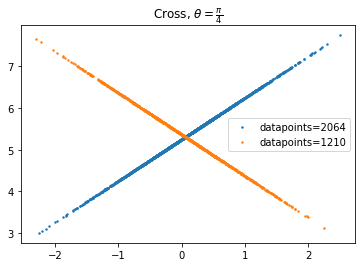

In [87]:
file = 'outputs/dataset_2_cross_rotation_angle_025pi_noise_False.pickle'
plot_scatter(data, reduction_type="TSNE", file_name=file[:-7],
             title="Cross," + " $\\theta = \\frac{\pi}{4}$")

In [111]:
data, mus, sigmas = cross(rotation_angle_1=pi/4, rotation_angle_2=-pi/4, noise=True, data_size=1000)

In [113]:
with open('outputs/dataset_2_cross_rotation_angle_025pi_noise_True.pickle', 'wb') as handle:
    pickle.dump([data, mus, sigmas], handle, protocol=pickle.HIGHEST_PROTOCOL)

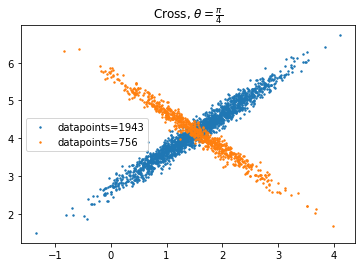

In [114]:
file = 'outputs/dataset_2_cross_rotation_angle_025pi_noise_True.pickle'
plot_scatter(data, reduction_type="TSNE", file_name=file[:-7],
             title="Cross," + " $\\theta = \\frac{\pi}{4}$")

Dataset 3

Sinusoidal patterns

In [129]:
data_size = 1000
data = []
data_sizes = np.random.randint(low=data_size, high=5*data_size, size=2)
x = np.random.multivariate_normal(np.array([2.5]), np.array([[1]]), data_sizes[0])
e = np.random.multivariate_normal(np.array([0]), np.array([[0.005]]), data_sizes[0])
y = np.sin(x)
data.append(np.concatenate([x, y + e], axis=1))

x = np.random.multivariate_normal(np.array([2.5]), np.array([[1]]), data_sizes[1])
e = np.random.multivariate_normal(np.array([0]), np.array([[0.005]]), data_sizes[1])
y = np.sin(x) + 1
data.append(np.concatenate([x, y + e], axis=1))

In [131]:
with open('outputs/dataset_3_sinusoidal_2_clusters.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

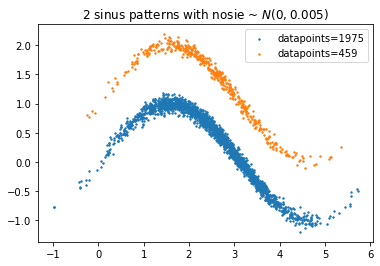

In [133]:
file = 'outputs/dataset_3_sinusoidal_2_clusters.pickle'
plot_scatter(data, reduction_type="TSNE", file_name=file[:-7],
             title="2 sinus patterns with nosie ~ $N(0, 0.005)$")

In [148]:
data_size = 1000
data = []
data_sizes = np.random.randint(low=data_size, high=5*data_size, size=3)

x = np.random.multivariate_normal(np.array([2.5]), np.array([[1]]), data_sizes[0])
e = np.random.multivariate_normal(np.array([0]), np.array([[0.005]]), data_sizes[0])
y = np.cos(x)
data.append(np.concatenate([x, y + e], axis=1))

x = np.random.multivariate_normal(np.array([2.5]), np.array([[1]]), data_sizes[1])
e = np.random.multivariate_normal(np.array([0]), np.array([[0.005]]), data_sizes[1])
y = np.sin(x)
data.append(np.concatenate([x, y + e], axis=1))

x = np.random.multivariate_normal(np.array([2.5]), np.array([[1]]), data_sizes[2])
e = np.random.multivariate_normal(np.array([0]), np.array([[0.005]]), data_sizes[2])
y = np.sin(x) + 1 
data.append(np.concatenate([x, y + e], axis=1))

In [150]:
with open('outputs/dataset_3_sinusoidal_3_clusters.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

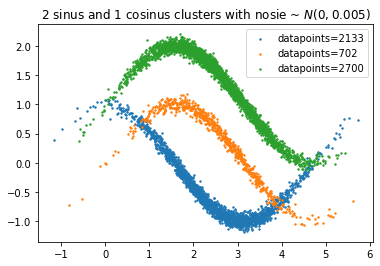

In [151]:
file = 'outputs/dataset_3_sinusoidal_3_clusters.pickle'
plot_scatter(data, reduction_type="TSNE", file_name=file[:-7],
             title="2 sinus and 1 cosinus clusters with nosie ~ $N(0, 0.005)$")

In [152]:
data_size = 3000
data = []
data_sizes = np.random.randint(low=data_size, high=5*data_size, size=2)

rotation_angle = pi/8
R = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)], [np.sin(rotation_angle), np.cos(rotation_angle)]])
U = np.array([[1, 0],[0, 1]])
U = R @ U
EV = np.diag([1, 0.009])
S = U @ EV @ (U.T)
x = 1.5*np.random.multivariate_normal(np.array([2.5, 1]), S, data_sizes[0])
y = np.sin(x[:, 0])
data.append(np.array([x[:, 0], y + x[:, 1]]).T)

rotation_angle = -pi/4
R = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)], [np.sin(rotation_angle), np.cos(rotation_angle)]])
U = np.array([[1, 0],[0, 1]])
U = R @ U
EV = np.diag([1, 0.009])
S = U @ EV @ (U.T)
x = np.random.multivariate_normal(np.array([-1.5,1]), S, data_sizes[1])
data.append(np.array([x[:,0], x[:,1]]).T)

In [155]:
with open('outputs/dataset_3_rotated_sinusoidal_and_line.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

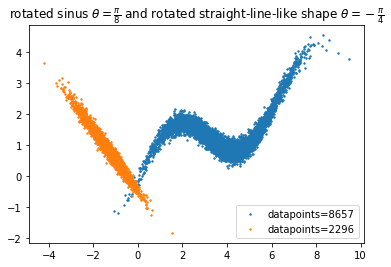

In [159]:
file = 'outputs/dataset_3_rotated_sinusoidal_and_line.pickle'
plot_scatter(data, reduction_type="TSNE", file_name=file[:-7],
             title="rotated sinus $\\theta = \\frac{\pi}{8}$ and rotated straight-line-like shape $\\theta = -\\frac{\pi}{4}$")

In [54]:
def circle(radiuses, rotation_angles=None, centers=None, eigenvalues_s=None, data_size=500):
    """
    generate 2D circles clusters. circle points points and noise are sampled
    from random multivariate normal distributions.

    Parameters
    ----------
    radiuses : List or any sequential structre that holds the circles cluster radius.
    rotation_angles : None or List or any sequential structre that holds the circles cluster rotation angles in radians.
                      Define the rotation angle of the rotation matrix that multiplies the eigenvectors
                      matrix of the covariance. This is not rotation, just making the noise the circle points dependent.
                      If None, no rotation. Default: None
    centers : None or List or any sequential structre that holds the circles' centers coordinates. 
              Coordinates are numpy array of shape (2,1) or (2,). If None, center at origin. Default: None
    eigenvalues_s : None or List or any sequential structre that holds the covariance eigenvalues of circles points and noise.
                    Eigenvalues are List or any sequential structre of size 2.
                    If None, [5, 0.01] is the eigenvalue for each circle pattern. Default: None
    data_size : int, define a range [data_size, 5*data_size] from which the cluster sizes are randomly choosen.
                Default: 500

    Returns
    -------
    data : List that holds the cluster data. For example, [xks_1, xks_2, ...]
           where xks_i is a numpy array of n datapints of dimension m (n,m) of cluster i
    """
    data_sizes = np.random.randint(low=data_size, high=5*data_size, size=len(radiuses))
    data = []
    for i, r in enumerate(radiuses):
        rotation_angle = 0 if rotation_angles is None else rotation_angles[i]
        center = np.array([0, 0]) if centers is None else centers[i]
        eigen_valus = [5, 0.01] if eigenvalues_s is None else eigenvalues_s[i]
        
        R = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)], [np.sin(rotation_angle), np.cos(rotation_angle)]])
        U = np.array([[1, 0],[0, 1]])
        U = R @ U
        EV = np.diag(eigen_valus)
        S = U @ EV @ (U.T)
        points = np.random.multivariate_normal(center, S, data_sizes[i]) # points[:, 1] is the noise 
        x = r * np.sin(points[:, 0])
        y = r * np.cos(points[:, 0])
        data.append(np.array([x + points[:, 1], y + points[:, 1]]).T)
    
    return data

In [27]:
data = circle(radiuses=[5, 3])

In [30]:
with open('outputs/dataset_3_circles_same_center_r_5_3_rotation_angle_0_0_noise_True.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

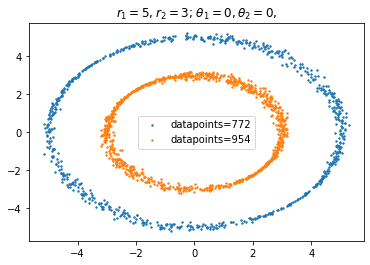

In [31]:
file = 'outputs/dataset_3_circles_same_center_r_5_3_rotation_angle_0_0_noise_True.pickle'
plot_scatter(data, reduction_type="TSNE", file_name=file[:-7],
             title="$r_1 = 5, r_2 = 3$; $\\theta_1 = 0, \\theta_2 = 0,$")

In [57]:
data = circle(radiuses=[5, 3, 2], centers=[np.array([0,0]), np.array([3,3]), np.array([-7, -7])])

In [59]:
with open('outputs/dataset_3_circles_different_center_r_5_3_2_rotation_angle_0_0_0_noise_True.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

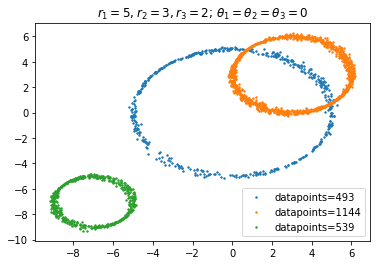

In [60]:
file = 'outputs/dataset_3_circles_different_center_r_5_3_2_rotation_angle_0_0_0_noise_True.pickle'
plot_scatter(data, reduction_type="TSNE", file_name=file[:-7],
             title="$r_1 = 5, r_2 = 3, r_3 = 2$; $\\theta_1 = \\theta_2 = \\theta_3 = 0$")

In [65]:
data = circle(radiuses=[5, 1], rotation_angles=[0, pi/16], eigenvalues_s=[[5, 0.001], [25, 0.001]])

In [68]:
with open('outputs/dataset_3_circles_same_center_r_5_1_rotation_angle_0_pidiv16_noise_True.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

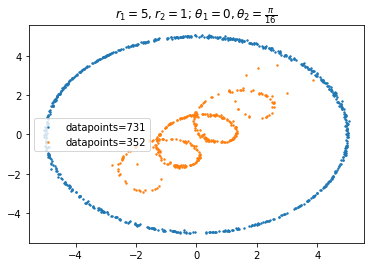

In [69]:
file = 'outputs/dataset_3_circles_same_center_r_5_1_rotation_angle_0_pidiv16_noise_True.pickle'
plot_scatter(data, reduction_type="TSNE", file_name=file[:-7],
             title="$r_1 = 5, r_2 = 1$; $\\theta_1 = 0, \\theta_2 = \\frac{\pi}{16}$")

In [72]:
def sphere(radiuses, centers=None, eigenvalues_s=None, data_size=2000, rotation_angles=None):
    """
    generate 3D spheres clusters. spheres points points and noise are sampled
    from random multivariate normal distributions.

    Parameters
    ----------
    radiuses : List or any sequential structre that holds the spheres cluster radius.
    centers : None or List or any sequential structre that holds the spheres' centers coordinates. 
              Coordinates are numpy array of shape (3,1) or (3,). If None, center at origin. Default: None
    eigenvalues_s : None or List or any sequential structre that holds the covariance eigenvalues of spheres points and noise.
                    Eigenvalues are List or any sequential structre of size 3.
                    If None, [5, 5, 0.1] is the eigenvalue for each sphere pattern. Default: None
    data_size : int, define a range [data_size, 5*data_size] from which the cluster sizes are randomly choosen.
                Default: 2000
    rotation_angles : None or List or any sequential structre that holds the spheres cluster rotation angles in radians.
                      Define the rotation angle of the rotation matrix that multiplies the eigenvectors
                      matrix of the covariance. This is not rotation, just making the noise the spheres points dependent.
                      If None, no rotation. Default: None
    Returns
    -------
    data : List that holds the cluster data. For example, [xks_1, xks_2, ...]
           where xks_i is a numpy array of n datapints of dimension m (n,m) of cluster i
    """
    data_sizes = np.random.randint(low=data_size*0.3, high=data_size*3, size=len(radiuses))
    data = []
    for i, r in enumerate(radiuses):
        rotation_angle = 0 if rotation_angles is None else rotation_angles[i]
        center = np.array([0, 0, 0]) if centers is None else centers[i]
        eigen_valus = [5, 5, 0.1] if eigenvalues_s is None else eigenvalues_s[i]
        
        R = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)], [np.sin(rotation_angle), np.cos(rotation_angle)]])
        U = np.array([[1, 0, 0],[0, 1, 0], [0, 0, 1]])
        EV = np.diag(eigen_valus)
        S = U @ EV @ (U.T)
        points = np.random.multivariate_normal(center, S, data_sizes[i])
        x,y,z = r * np.cos(points[:, 0]) * np.sin(points[:, 1]), r * np.sin(points[:, 0]) * np.sin(points[:, 1]), r * np.cos(points[:, 1])
        data.append(np.array([x + points[:, 2], y + points[:, 2], z + points[:, 2]]).T)
    
    return data

In [87]:
data = sphere(radiuses=[5, 2])

In [89]:
with open('dataset_3_sphere_same_center_r_5_2_rotation_angle_0_0_noise_True.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

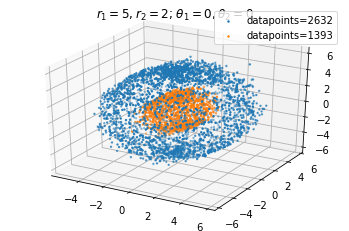

In [90]:
file = 'dataset_3_sphere_same_center_r_5_2_rotation_angle_0_0_noise_True.pickle'
plot_scatter(data, reduction_type="TSNE", file_name=file[:-7],
             title="$r_1 = 5, r_2 = 2$; $\\theta_1 = 0, \\theta_2 = 0$")

In [148]:
def moon(radiuses, shifts, orientations, rotation_angles=None, centers=None, eigenvalues_s=None, data_size=1000):
    """
    generate 2D moon clusters. moon points points and noise are sampled
    from random multivariate normal distributions. Based on half ellipse equation.

    Parameters
    ----------
    radiuses : List or any sequential structre that holds the moon cluster width and height.
               For example, [np.array([a1, b1]), np.array([a2, b2]), ...]
    shifts : List or any sequential structre that holds the shift size of cluster points.
             For example, [np.array([delta_x_1, delta_y_1]), np.array([delta_x_2, delta_y_2]), ...]
    orientations : List or any sequential structre that holds the orientations of the half ellipse
                   clusters (concave or convex). For example, [1, -1, ...].
    otation_angles : None or List or any sequential structre that holds the half ellipse cluster rotation angles in radians.
                      Define the rotation angle of the rotation matrix that multiplies the eigenvectors
                      matrix of the covariance. This is not always rotation, just making the noise the half ellipse points dependent.
                      If None, no rotation. Default: None
    centers : None or List or any sequential structre that holds the half ellipses' centers coordinates.
              Coordinates are numpy array of shape (2,1) or (2,). If None, center at origin. Default: None
    eigenvalues_s : None or List or any sequential structre that holds the covariance eigenvalues of half ellipses points and noise.
                    Eigenvalues are List or any sequential structre of size 3.
                    If None, the eigenvalue randomly selected. Default: None
    data_size : int, define a range [data_size, 5*data_size] from which the cluster sizes are randomly choosen.
                Default: 1000

    Returns
    -------
    data : List that holds the cluster data. For example, [xks_1, xks_2, ...]
           where xks_i is a numpy array of n datapints of dimension m (n,m) of cluster i
    """
    data_sizes = np.random.randint(low=data_size*0.3, high=data_size*3, size=len(radiuses))
    data = []
    for i, r in enumerate(radiuses):
        orientation = orientations[i]
        delta_x, delta_y = shifts[i][0], shifts[i][1]
        a, b = r[0], r[1]
        delta_x, delta_y
        rotation_angle = 0 if rotation_angles is None else rotation_angles[i]
        center = np.array([0, 0]) if centers is None else centers[i]
        eigen_valus = [a, np.abs(np.random.normal(0, 0.01, 1))] if eigenvalues_s is None else eigenvalues_s[i]
        
        R = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)], [np.sin(rotation_angle), np.cos(rotation_angle)]])
        U = np.array([[1, 0],[0, 1]])
        U = R @ U
        EV = np.diag(eigen_valus)
        S = U @ EV @ (U.T)
        points = np.random.multivariate_normal(center, S, data_sizes[i])
        x = points[:, 0]
        y = orientation * b/a * np.sqrt(a ** 2 - x ** 2) + delta_y
        data.append(np.array([x + points[:, 1] + delta_x, y + points[:, 1]]).T)
    
    return data

In [149]:
data = moon(radiuses=[np.array([3,1]), np.array([3, 1])], shifts=[np.array([0,0]), np.array([1, 0.5])], orientations=[1, -1])

/users/agnon/year2016/yaishof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt


In [151]:
with open('dataset_3_moon_2_clusters_noise_True.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

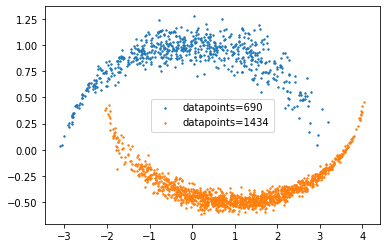

In [152]:
file = 'dataset_3_moon_2_clusters_noise_True.pickle'
plot_scatter(data, reduction_type="TSNE", file_name=file[:-7])

In [165]:
data = moon(radiuses=[np.array([3,1]), np.array([3, 1])], shifts=[np.array([0,0]), np.array([1, 0.5])], orientations=[1, -1], rotation_angles=[pi/8, pi/8])

/users/agnon/year2016/yaishof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt


In [167]:
with open('outputs/dataset_3_moon_2_clusters_rotated_noise_True.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

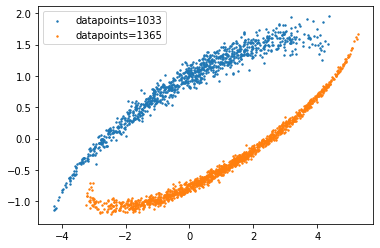

In [168]:
file = 'outputs/dataset_3_moon_2_clusters_rotated_noise_True.pickle'
plot_scatter(data, reduction_type="TSNE", file_name=file[:-7])

Dataset 4

In [1]:
from sklearn.datasets import load_iris
iris_dataset = load_iris()
xks = iris_dataset.data
ind = iris_dataset.target
data = [xks[np.where(ind == i)[0], :] for i in np.unique(ind)]

In [2]:
print(iris_dataset.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [25]:
iris_df = pd.DataFrame(data={"sepal-length": xks[:,0], "sepal-width": xks[:,1],
                             "petal-length": xks[:,2], "petal-width": xks[:,3],
                              "Iris type": ind})

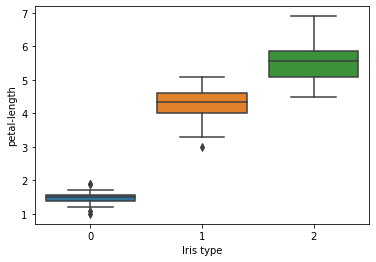

In [29]:
file_name = "outputs/iris_petal_length_box_plot"
sns.boxplot(x="Iris type", y="petal-length", data=iris_df)
plt.savefig('{}.png'.format(file_name), bbox_inches='tight')

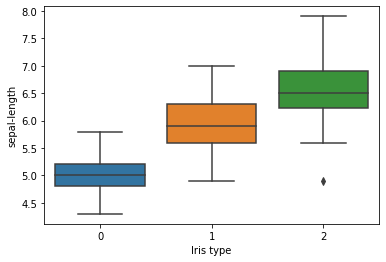

In [30]:
file_name = "outputs/iris_sepal_length_box_plot"
sns.boxplot(x="Iris type", y="sepal-length", data=iris_df)
plt.savefig('{}.png'.format(file_name), bbox_inches='tight')

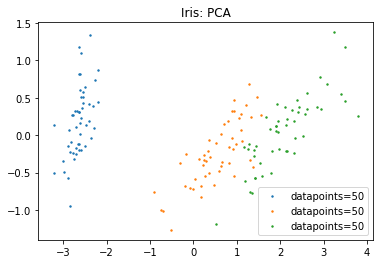

In [33]:
plot_scatter(data, reduction_type="PCA", file_name="outputs/iris_PCA_2D.png", title="Iris: PCA")

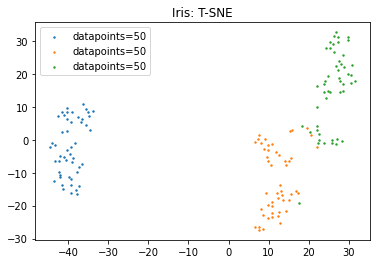

In [34]:
plot_scatter(data, reduction_type="TSNE", file_name="outputs/iris_TSNE_2D.png", title="Iris: T-SNE")

In [31]:
from sklearn.datasets import load_wine
wine_dataset = load_wine()
xks = wine_dataset.data
ind = wine_dataset.target
data = [xks[np.where(ind == i)[0], :] for i in np.unique(ind)]

In [32]:
print(wine_dataset.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

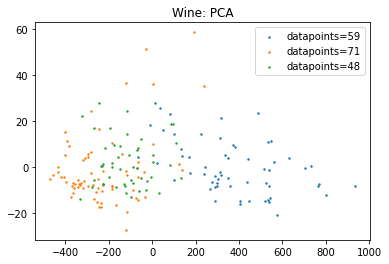

In [35]:
plot_scatter(data, reduction_type="PCA", file_name="outputs/wine_PCA_2D.png", title="Wine: PCA")

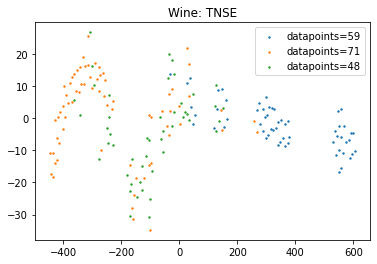

In [36]:
plot_scatter(data, reduction_type="TSNE", file_name="outputs/wine_TSNE_2D.png", title="Wine: TNSE")